In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  9 00:01:55 2023

@author: Aditya Pavadad
"""

"""
"""

# ---- Import libraries ----
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import csv


# ---- Parameters ----

"""Importing the dataset and extracting the appropriate data"""

filename = "data_small_3dep.txt"


with open(filename) as f:
    data = csv.reader(f, delimiter="\t")
    dataset = list(data)

for i in range(0,len(dataset)):
    for j in range(0,7):
        a = int(dataset[i][j])
        dataset[i][j] = a
        
dataset = np.array(dataset)
node_id = dataset[:, 0]  # Stores the id's of the nodes
x_coord = dataset[:, 1]  # Stores the x coordinates of all the nodes
y_coord = dataset[:, 2]  # Stores the y coordinates of all the nodes
a = dataset[:, 3]  # Stores the demand for each node
RT = dataset[:, 4]  # Stores the ready time for each node (earliest time for delivery)
DT = dataset[:, 5]  # Stores the due time for each node (latest time for delivery)
ST = dataset[:, 6]  # Stores the service time for each node (time needed for a delivery at each location )

"""Parameters"""

# Capacities for each vehicle.

b = np.array([130 , 130 , 130]) 

# b = np.array([300 , 300 , 300 , 300, 300, 300]) 
# Dc = np.array([5, 0, 0])


# Total number of vehicles
K = len(b)

"""Calculating the Euclidean distance between all nodes """

D = np.zeros((len(a), len(a)))


for i in range(len(node_id)):
    for j in range(len(node_id)):
        D[i, j] = np.linalg.norm((x_coord[i] - x_coord[j], y_coord[i] - y_coord[j]))
        


# ---- Initialising Model ----

model = Model("Part c/d")


# ---- Sets and Indices ----

I = range(len(node_id))  # locations
J = range(len(node_id))  # locations
V = range(K)  # vehicles

# ---- Decision Variables ----

"""Initialising the dimensions for all the decision variables"""
x = model.addVars(I, J, V, vtype = GRB.BINARY, name = "If_Route_Travelled")
z = model.addVars(I, V, vtype = GRB.BINARY, name = "If_Node_Satisfied")
t = model.addVars(I, V, vtype = GRB.CONTINUOUS, name = "Service_Start_Time")
N = model.addVars(range(3), lb = 0, ub = K, vtype = GRB.INTEGER, name = "Vehicle_Per_Depot")
    
    
# # ---- Integerate the variables into the model ----
model.update()


# # ---- Objective Function ----
obj = quicksum(x[i, j, v]*D[i, j] for i in I for j in J for v in V) + 5*N[0]
model.setObjective(obj, GRB.MINIMIZE)  # Only a function of distance as that is the parameter to minimize

model.update()

# # ---- Constraints ----

M = 2000

# # Ensures that every node is visited by only one vehicle
single_visit = model.addConstrs((quicksum(z[i, v] for v in V) == 1 for i in range(3, len(a))), 
                                "Single_Visit_Satisfaction")

# # Ensures that multiple vehicles can start from the Depot
depot_vehicle_num = model.addConstrs((quicksum(z[i, v] for v in V) == N[i] for i in range(3)), 
                                     "Vehicle_Leaving_Depot")
    
# # Total Number of Vehicles leaving the depots is K
total_vehicles = model.addConstr(quicksum(N[i] for i in range(3)) == K, "Total_Vehicles")    

# # Ensures that the sum of demand of a tour of each vehicle needs to be less than overall capacity of the vehicle
vehicle_cap = model.addConstrs((quicksum(a[i]*z[i, v] for i in I) <= b[v] for v in V), "Vehicle_Capacity")

# # Ensures that the number of vehicles leaving a node equals number of vehicles satisfying its demands
vehicle_departure = model.addConstrs((quicksum(x[i, j, v] for j in J) == z[i, v] for i in I for v in V), 
                                     "Vehicle_Departure_Constraint")

# # Ensures that each nodes is visited by particular vehicle v once
vehicle_arrival = model.addConstrs((quicksum(x[i, j, v] for i in I) == z[j, v] for j in J for v in V), 
                                   "Vehicle_Arrival_Constraint")

# # Defining the total time taken up to a certain node for a certain vehicle
service_start = model.addConstrs((quicksum(x[i, j, v]*(t[i, v] + ST[i] + D[i, j]) for i in I) <= t[j, v] 
                                  for j in range(3, len(a)) for v in V), 
                                 "Service_Start_Time_Constraint")

# # Ensures that there is no subtouring
subtour_constraint = model.addConstrs((t[i, v] + D[i, j] - M*(1 - x[i, j, v]) <= t[j, v] 
                                       for i in I for j in range(3, len(a)) for v in V), "Subtour_Constraint")

# # Ensures that the arrival of the vehicle is within the ready-time and due-time
ready_time_constraint = model.addConstrs((RT[i]*z[i, v] <= t[i, v] for i in I for v in V), "Ready_Time_Constraint")
due_time_constraint = model.addConstrs((t[i, v] <= DT[i]*z[i, v] for i in I for v in V), "Due_Time_Constraint")




model.update()

model.setParam("OutputFlag", 1)  # silencing gurobi output or not
model.setParam('MIPGap', 2)
model.setParam('TimeLimit', 1800)

# # find the optimal solution
# model.write("output.lp")  # print the model in .lp format file


# Solve the model
model.optimize()





Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-14
Set parameter MIPGap to value 2
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1544 rows, 1587 columns and 7068 nonzeros
Model fingerprint: 0x5d5892f7
Model has 57 quadratic constraints
Variable types: 66 continuous, 1521 integer (1518 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+02]
  Objective range  [2e+00, 8e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 291 rows and 225 columns
Presolve time: 0.03s
Presolved: 2342 rows, 2394 columns, 11103 nonzeros
Variable types: 918 continuous, 1476 integer (1296 binary)
Found heuristic solution: objecti

In [2]:
# Print the objective value and GAP
print("Objective Value:", model.objVal)
print("Best Bound:", model.objBound)
print("MIP Gap:", abs((model.objVal - model.objBound) / model.objVal))


Objective Value: inf
Best Bound: 205.43047293570515
MIP Gap: nan


In [3]:
import pandas as pd

def conv(y):
    return round(y.x)

In [4]:
df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)
# df3 = pd.DataFrame(np.array(x)[:,:,3]).applymap(conv)
# df4 = pd.DataFrame(np.array(x)[:,:,4]).applymap(conv)
# df5 = pd.DataFrame(np.array(x)[:,:,5]).applymap(conv)

route = [[], [], []]

route[0].append(df0[:3].sum(axis=1)[df0[:3].sum(axis=1) == 1].index[0])
route[1].append(df1[:3].sum(axis=1)[df1[:3].sum(axis=1) == 1].index[0])
route[2].append(df2[:3].sum(axis=1)[df2[:3].sum(axis=1) == 1].index[0])
# route[3].append(df3[:3].sum(axis=1)[df2[:3].sum(axis=1) > 0].index[0])
# route[4].append(df4[:3].sum(axis=1)[df2[:3].sum(axis=1) > 0].index[0])
# route[5].append(df5[:3].sum(axis=1)[df2[:3].sum(axis=1) > 0].index[0])

i = 0
while True:
    route[0].append(df0.iloc[route[0][i]][df0.iloc[route[0][i]] == 1].index[0])
    i += 1
    if route[0][i] == route[0][0]:
        break
        
i = 0
while True:
    route[1].append(df1.iloc[route[1][i]][df1.iloc[route[1][i]] == 1].index[0])
    i += 1
    if route[1][i] == route[1][0]:
        break
        
i = 0
while True:
    route[2].append(df2.iloc[route[2][i]][df2.iloc[route[2][i]] == 1].index[0])
    i += 1
    if route[2][i] == route[2][0]:
        break
        
# i = 0
# while True:
#     route[3].append(df3.iloc[route[3][i]][df3.iloc[route[3][i]] > 0].index[0])
#     i += 1
#     if route[3][i] == route[3][0]:
#         break
        
# i = 0
# while True:
#     route[4].append(df4.iloc[route[4][i]][df4.iloc[route[4][i]] > 0].index[0])
#     i += 1
#     if route[4][i] == route[4][0]:
#         break
        
# i = 0
# while True:
#     route[5].append(df5.iloc[route[5][i]][df5.iloc[route[5][i]] > 0].index[0])
#     i += 1
#     if route[5][i] == route[5][0]:
#         break

C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_24336\1510594184.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_24336\1510594184.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_24336\1510594184.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
route

IndexError: index 0 is out of bounds for axis 0 with size 0

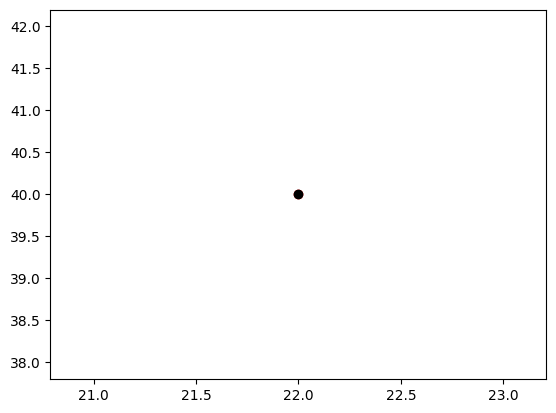

In [5]:
filename = "cccc.txt"

with open(filename, "r") as file:
    file_content = file.read()



data = []
for line in file_content.split('\n'):
    data.append(line.split())

dat = np.array(data, dtype = 'int')

# route

x_coords = []
y_coords = []
for path in route:
    x_coords.append(dat[path, 1])
    y_coords.append(dat[path, 2])

# x_coords

# y_coords

plt.plot(x_coords[0], y_coords[0], 'ro-', lw = 1);
plt.plot(x_coords[0][0], y_coords[0][0], 'ko');


plt.plot(x_coords[1], y_coords[1], 'go-', lw = 1);
plt.plot(x_coords[2], y_coords[2], 'bo-', lw = 1);
plt.plot(x_coords[1][0], y_coords[1][0], 'ko');
plt.plot(x_coords[2][0], y_coords[2][0], 'ko');

In [6]:
route

[[1], [], []]

In [ ]:
if model.status == GRB.Status.OPTIMAL:
    print('\n' + 'Solution to part E/F: ')

    print('\n' + 'Case Parameters: ')
    print('\n' + 'Number of vehicles: ' + str(K))
    print('\n' + 'Capacity of each vehicle: ' + str(b[0]))


    #Total Distance Travelled
    print ('\n Total distance for all vehicles for all deliveries: %10.2f Units of Distance' % model.objVal)

    #Sequence of locations visited by each vehicle
    fig, ax = plt.subplots()
    route = []
    for v in V:
        print ('\n Tour of vehicle no. ' + str(v+1) + ' is: ')
        k = 0
        orderofvisit = [0]
        lenz = 0
        for i in I:
            value = z[i][v].x
            lenz = lenz + value
        while k < lenz:
            i = orderofvisit[k]
            for j in I:
                if x[i][j][v].x == 1:
                    orderofvisit.append(j)
                    k = k + 1
        print('\t' + str(orderofvisit))
        route.append(orderofvisit)
        #Time of visit at each location by each vehicle:
        total_time_v = 0
        print ('\n Time of visit at each node by vehicle no. ' + str(v+1) + ' is: ')
        for i in range(len(orderofvisit)-1):
            time = '%0.2f' % t[int(orderofvisit[i])][v].x
            print('\t' + str(time))

        #Load of each vehicle at each location:
        print ('\n Load of vehicle no. ' + str(v+1) + ' at each location in the route:')
        for i in range(len(orderofvisit)-1):
            load = '%0.2f' % L[int(orderofvisit[i])][v].x
            print('\t' + str(load))


         #2D plot of the solution
        x_pos_order = []
        y_pos_order = []
        col = (np.random.random(), np.random.random(), np.random.random())
        #colors ['']
        for i in range(len(orderofvisit)):

            j = int(orderofvisit[i])
            x_pos_order.append(x_coord[j])
            y_pos_order.append(y_coord[j])


            ax.plot(x_pos_order, y_pos_order, '.-', lw = 1, color = col)
            plt.xlabel("X Coordinate Position")
            plt.ylabel("Y Coordinate Position")
            plt.title("2D Plot of the Solution")


            txt = j
            ax.annotate(txt, (x_pos_order[i], y_pos_order[i]),fontsize = 10)
            ax.annotate('',
                                xytext=(x_pos_order[i-1], y_pos_order[i-1]),
                                xy=(x_pos_order[i], y_pos_order[i]),
                                size=5)

#             txt = j
#             ax.annotate(txt, (x_pos_order[i], y_pos_order[i]),fontsize = 15)
#             ax.annotate('',
#                                  xytext=(x_pos_order[i-1], y_pos_order[i-1]),
#                                  xy=(x_pos_order[i], y_pos_order[i]),
#                                  arrowprops=dict(arrowstyle="->", color= col),
#                                  size=10)
else:
    print ('\nNo feasible solution found')

In [ ]:
x

In [ ]:
orderofvisit

In [ ]:
z